C:\Users\acer\AppData\Local\Temp\ipykernel_9376\3624340162.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query_mysql, mysql_conn)


Kolom & dtypes:
id         int64
mcg      float64
gvh      float64
lip      float64
chg      float64
aac      float64
alm1     float64
alm2     float64
class     object
dtype: object
Terpilih sebagai label: class
Kolom numerik digunakan untuk PCA/ADASYN: ['id', 'mcg', 'gvh', 'lip', 'chg', 'aac', 'alm1', 'alm2']
After dropna shape: (336, 9)
Class mapping: {0: 'cp', 1: 'im', 2: 'imL', 3: 'imS', 4: 'imU', 5: 'om', 6: 'omL', 7: 'pp'}
Distribusi awal: Counter({0: 143, 1: 77, 7: 52, 4: 35, 5: 20, 6: 5, 3: 2, 2: 2})


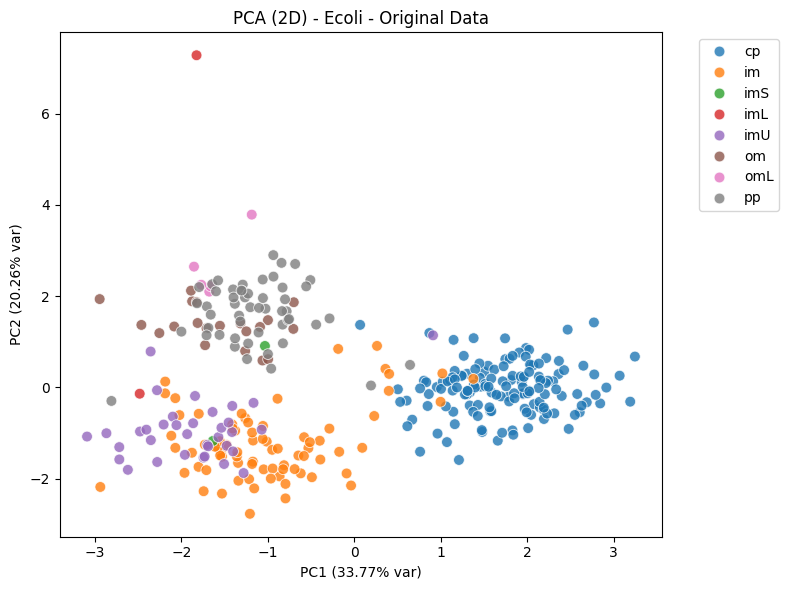

Counts before balancing:
class
cp     143
im      77
pp      52
imU     35
om      20
omL      5
imS      2
imL      2
Name: count, dtype: int64
Distribusi sebelum: Counter({0: 143, 1: 77, 7: 52, 4: 35, 5: 20, 6: 5, 3: 2, 2: 2})
Distribusi setelah ROS: Counter({0: 143, 1: 143, 3: 143, 2: 143, 4: 143, 5: 143, 6: 143, 7: 143})
Shape sebelum: (336, 8) → sesudah: (1144, 8)
Distribusi sesudah ADASYN: Counter({0: 143, 1: 143, 3: 143, 2: 143, 4: 143, 5: 143, 6: 143, 7: 143})


NameError: name 'X_pca_before' is not defined

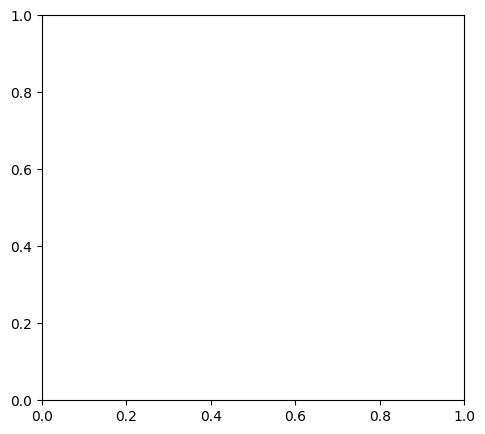

In [1]:
import pandas as pd
import pymysql
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from imblearn.over_sampling import ADASYN, RandomOverSampler
from collections import Counter

# Koneksi ke MySQL
mysql_conn = pymysql.connect(
    host="mysql-3c768195-aqbilbaraka.d.aivencloud.com",
    user="avnadmin",
    password="AVNS_WV9i6KvYoQZ3s6FclWP",
    database="defaultdb",
    port=16932,
    ssl={"ssl": {}}
)

# Query tabel ecoli
query_mysql = "SELECT * FROM defaultdb.ecoli"
df = pd.read_sql(query_mysql, mysql_conn)

# Lihat data
df.head()


# Identifikasi kolom non-numeric
print("Kolom & dtypes:")
print(df.dtypes)

# Cari kolom label (kelas). Logika: pilih kolom bertipe object/string dengan nunique < n
possible_labels = [c for c in df.columns if df[c].dtype == object or df[c].dtype.name == 'category']
label_col = None
for c in possible_labels:
    if df[c].nunique() < len(df):
        label_col = c
        break

# Jika tidak ketemu, kamu harus set manual
if label_col is None:
    # contohnya: label_col = 'class'    # ganti jika perlu
    raise ValueError("Tidak menemukan kolom label otomatis. Set 'label_col' manual sesuai dataset (mis. 'class').")

print("Terpilih sebagai label:", label_col)

# Pilih fitur numerik (exclude id / label)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Kadang dataset UCI menyertakan index/sequence name sebagai kolom object unik - pastikan mengeluarkannya
print("Kolom numerik digunakan untuk PCA/ADASYN:", num_cols)

# Jika kolom numerik kosong (misalnya data numeric tersimpan sebagai string), konversi:
# df['mcg'] = pd.to_numeric(df['mcg'], errors='coerce')  # contoh

# Buat salinan kerja
df_proc = df.copy()

# Drop rows dengan missing pada fitur numerik (atau lakukan imputasi bila ingin)
df_proc = df_proc.dropna(subset=num_cols)
print("After dropna shape:", df_proc.shape)
label_col = df.columns[-1]

# X (fitur numerik) dan y (label)
X = df_proc[num_cols].values
y = df_proc[label_col].values

# Encode label ke integer untuk ADASYN & plotting
le = LabelEncoder()
y_enc = le.fit_transform(y)
class_names = le.classes_
print("Class mapping:", dict(enumerate(class_names)))

# Standardize fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Pisahkan fitur & target
X = df.drop(columns=["class"])
y = df["class"]

# Encode label target (class → angka)
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Standarisasi fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Distribusi awal:", Counter(y_enc))

# Fit PCA pada data asli (2 komponen)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Buat DataFrame untuk plotting
df_pca = pd.DataFrame(X_pca, columns=['PC1','PC2'])
df_pca[label_col] = y
df_pca['label_enc'] = y_enc

# Plot scatter 2D hasil PCA
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue=label_col, palette='tab10', s=60, edgecolor='w', alpha=0.8)
plt.title("PCA (2D) - Ecoli - Original Data")
plt.xlabel("PC1 (%.2f%% var)" % (pca.explained_variance_ratio_[0]*100))
plt.ylabel("PC2 (%.2f%% var)" % (pca.explained_variance_ratio_[1]*100))
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

orig_counts = pd.Series(y).value_counts()
print("Counts before balancing:")
print(orig_counts)

print("Distribusi sebelum:", Counter(y_enc))

ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_scaled, y_enc)

print("Distribusi setelah ROS:", Counter(y_ros))

adasyn = ADASYN(random_state=42, n_neighbors=1)  # n_neighbors=1 agar aman
X_res, y_res = adasyn.fit_resample(X_ros, y_ros)

print("Shape sebelum:", X_scaled.shape, "→ sesudah:", X_res.shape)
print("Distribusi sesudah ADASYN:", Counter(y_res))

# Transformasi PCA
X_pca_after = pca.fit_transform(X_res)

plt.figure(figsize=(12,5))

# Sebelum balancing
plt.subplot(1,2,1)
scatter1 = plt.scatter(X_pca_before[:,0], X_pca_before[:,1], 
                       c=y_enc, cmap="tab10", alpha=0.7)
plt.title("PCA Sebelum Balancing")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(*scatter1.legend_elements(), title="Kelas")

# Sesudah balancing
plt.subplot(1,2,2)
scatter2 = plt.scatter(X_pca_after[:,0], X_pca_after[:,1], 
                       c=y_res, cmap="tab10", alpha=0.7)
plt.title("PCA Sesudah Balancing (ROS + ADASYN)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(*scatter2.legend_elements(), title="Kelas")

plt.tight_layout()
plt.show()

import seaborn as sns

# Hitung distribusi kelas
from collections import Counter
dist_before = Counter(y_enc)
dist_after = Counter(y_res)

# Konversi ke DataFrame biar enak diplot
df_dist = pd.DataFrame({
    "Kelas": list(dist_before.keys()),
    "Sebelum": list(dist_before.values()),
    "Sesudah": [dist_after[k] for k in dist_before.keys()]
})

# Plot side-by-side
df_melted = df_dist.melt(id_vars="Kelas", var_name="Kondisi", value_name="Jumlah")

plt.figure(figsize=(8,5))
sns.barplot(data=df_melted, x="Kelas", y="Jumlah", hue="Kondisi", palette="Set2")
plt.title("Distribusi Kelas Sebelum vs Sesudah Balancing")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Data")
plt.show()

print("Distribusi sebelum balancing:", dist_before)
print("Distribusi sesudah balancing:", dist_after)

